# Training Language Model

In this notebook we will train our LM model based on Bengio embedding method.

In [1]:
# Defining parameters

CONTEXT_SIZE = 5
BATCH_SIZE = 256
LR = 8e-3
HIDDEN_DIM = 128
EMBEDDING_DIM = 50

## Importing packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import collections
import itertools
import random
import torch

from transformers import GPT2LMHeadModel, GPT2Tokenizer

import torch.nn as nn

import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

from sklearn. model_selection import train_test_split
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

if torch.cuda.is_available(): 
    dev = "cuda:0"
else: 
    dev = "cpu"
device = torch.device(dev)
print('Using {}'.format(device))

Using cuda:0


In [3]:
# Setting up seeds
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
# Read dataset
data = pd.read_csv("../deliver/train/train.csv")
data.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# Function that builds our vocabulary
def build_vocab(tokens, vocab_size):
    word_frequency = collections.Counter(tokens)

    vocab = {token: index for index, (token, _) in enumerate(
        word_frequency.most_common(vocab_size))}

    # Adicionamos o token "<unk>" para lidar com palavras não presentes no
    # vocabulário . O dataset text8 já contem este token, mas pode ser que ele
    # não tenha sido adicionado quando filtramos com `vocab_size`.
    if '<unk>' not in vocab:
        vocab['<unk>'] = len(vocab)

    # Adicionando o padding como um token
    if '<pad>' not in vocab:
        vocab['<pad>'] = len(vocab)
        
    return vocab 

In [6]:
# Printing some examples
unique_tokens = ' '.join(data['text'].values).lower()
train_tokens = unique_tokens.split()
print(len(train_tokens))

523356


In [7]:
# Printing how many unique tokens is there
print('Length of unique tokens: ', len(set(train_tokens)))

Length of unique tokens:  44895


In [8]:
print('First 10 tokens:',train_tokens[:10])

First 10 tokens: ['this', 'process,', 'however,', 'afforded', 'me', 'no', 'means', 'of', 'ascertaining', 'the']


In [9]:
# Effectively building our vocabulary
vocab_size = 70000
vocab = build_vocab(train_tokens, vocab_size=vocab_size)

# Adding the 3 author in vocab
vocab['EAP'] = len(vocab) 
vocab['MWS'] = len(vocab)
vocab['HPL'] = len(vocab)

print(f"Encode for EAP: {vocab['EAP']} MWS: {vocab['MWS']} HPL: {vocab['HPL']}")

print(f'Vocab has {len(vocab)} tokens')
print(f'10 sample tokens: {list(itertools.islice(vocab.keys(), 10))}')

Encode for EAP: 44897 MWS: 44898 HPL: 44899
Vocab has 44900 tokens
10 sample tokens: ['the', 'of', 'and', 'to', 'a', 'i', 'in', 'was', 'that', 'my']


In [10]:
# Just an auxiliary "transposed" vocabulary to generate words
from collections import defaultdict
vocab_t = defaultdict(list)
for k, v in vocab.items():
    vocab_t[v].append(k)

In [11]:
import pickle

In [12]:
with open('vocab.pkl', 'wb') as f:
    pickle.dump(vocab, f)
    
with open('vocab_t.pkl', 'wb') as f:
    pickle.dump(vocab_t, f)

In [13]:
# Function that generate n grams https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
def get_ngrams(tokens, vocab ,n = 5):
    '''
    Função que recebe uma lista de tokens e retorna os índices, de acordo com o vocab, dos n-grams de tamanho n com base no vocab passado

    '''

    # Primeiro adicionamos n-1 <pad> no começo dos tokens
    local_tokens = (n-1)*['<pad>'] + tokens.copy() 

    # Array que guardará o vetor de contextos
    context_df = []
    # Array que guardará os tokens target para cada contexto
    target_token = []

  # Para cada token de 0 a len(tokens) - n - 1(já que vamos usar até i+n tokens por contexto e o i+n+1 é o target)
    for i in range(len(local_tokens) - n):
    # Vetor auxiliar que será incrementado ao context_df
        aux_df = []

        # Loop que percorre os primeiros n tokens
        for j in range(i, i+n):
            if(local_tokens[j] not in vocab):
                aux_df.append(vocab["<unk>"])
            else:
                aux_df.append(vocab[local_tokens[j]])

        # Incrementa o context_df
        context_df.append(aux_df)

        # Incrementa o target_token com o i+n+1 token
        if(local_tokens[i+n] not in vocab):
            target_token.append(vocab["<unk>"])
        else:
            target_token.append(vocab[local_tokens[i+n]])

    # Retorno numpy arrays por comodidade minha, mas poderiam ser tensores direto
    return context_df, target_token

In [14]:
def tokens2word(list_tokens, vocab_transposed):
    '''
        This function transform a list of tokens ids to string with the correspondent phrase.
    '''
    
    return ' '.join([vocab_transposed[t][0] for t in list_tokens])

In [15]:
# Example of usage
example = 'hey my name is lucas and i am pleasure to meet you! i really like how you are'
example = example.split()
encoded_tokens = get_ngrams(example, vocab ,n = 6)

print("ENCODED TOKENS:\n\n", encoded_tokens)

print("\n\nDECODED TOKENS:", 35*' ', "TARGET TOKEN","\n\n")
for i,f in enumerate(encoded_tokens[0]):
    print(tokens2word(list(f), vocab_t), 20*' ',tokens2word([encoded_tokens[1][i]], vocab_t))

ENCODED TOKENS:

 ([[44896, 44896, 44896, 44896, 44896, 33093], [44896, 44896, 44896, 44896, 33093, 9], [44896, 44896, 44896, 33093, 9, 304], [44896, 44896, 33093, 9, 304, 23], [44896, 33093, 9, 304, 23, 44895], [33093, 9, 304, 23, 44895, 2], [9, 304, 23, 44895, 2, 5], [304, 23, 44895, 2, 5, 118], [23, 44895, 2, 5, 118, 803], [44895, 2, 5, 118, 803, 3], [2, 5, 118, 803, 3, 833], [5, 118, 803, 3, 833, 44895], [118, 803, 3, 833, 44895, 5], [803, 3, 833, 44895, 5, 423], [3, 833, 44895, 5, 423, 76], [833, 44895, 5, 423, 76, 113], [44895, 5, 423, 76, 113, 35]], [9, 304, 23, 44895, 2, 5, 118, 803, 3, 833, 44895, 5, 423, 76, 113, 35, 56])


DECODED TOKENS:                                     TARGET TOKEN 


<pad> <pad> <pad> <pad> <pad> hey                      my
<pad> <pad> <pad> <pad> hey my                      name
<pad> <pad> <pad> hey my name                      is
<pad> <pad> hey my name is                      <unk>
<pad> hey my name is <unk>                      and
hey my name is 

Now, we are use this function just to iterate over our train dataset

In [16]:
def generate_df(df, vocab, vocab_t, len_context = 5):
    results_list = []
    target_list = []
    author_list = []
    
    i = 0
    for text, author in zip(df.text, df.author):
#         print([text],author)
#         print((author+' '+text).split())
        encoded = get_ngrams((author+' '+text).split(), vocab ,n = len_context)
#         print([text],encoded[0])
#         i+=1
#         if(i>10):
#             break
        
        results_list.extend(encoded[0])
        target_list.extend(encoded[1])
        author_list.extend(len(encoded[1])*[vocab[author]])
        
    return results_list, target_list, author_list

In [17]:
l, t, a = generate_df(data, vocab, vocab_t, len_context = CONTEXT_SIZE)

In [18]:
len(l)

523356

In [19]:
len(t)

523356

In [20]:
len(a)

523356

In [21]:
df = pd.DataFrame({'context': l, 'target': t, 'author': a})
df.head()

,context,target,author
0,"[44896, 44896, 44896, 44896, 44897]",44895,44897
1,"[44896, 44896, 44896, 44897, 44895]",8206,44897
2,"[44896, 44896, 44897, 44895, 8206]",141,44897
3,"[44896, 44897, 44895, 8206, 141]",1330,44897
4,"[44897, 44895, 8206, 141, 1330]",30,44897


In [22]:
# Spliting in train and validation dataset
df_train, df_val = train_test_split(df, test_size = 0.1, random_state = 42, shuffle= True, stratify=df.author)

df_val_authors = df_val.author

In [23]:
print('val size: ', df_val.shape)
df_val.head()

val size:  (52336, 3)


,context,target,author
51367,"[44895, 105, 35, 398, 30]",44895,44897
388580,"[44896, 44896, 44897, 44895, 37]",23,44897
44587,"[2, 243, 64, 3, 3104]",0,44899
439304,"[3876, 44895, 675, 4, 6225]",1451,44897
233289,"[40, 191, 3, 3894, 0]",44895,44897


In [24]:
# Transforming in torch tensors

# train
tensor_train = torch.tensor(df_train.context.tolist(), dtype=torch.long)
tensor_target_train = torch.tensor(df_train.target.tolist(), dtype=torch.long)
# valid
tensor_val = torch.tensor(df_val.context.tolist(), dtype=torch.long)
tensor_target_val = torch.tensor(df_val.target.tolist(), dtype=torch.long)

In [25]:
df_train = TensorDataset(tensor_train, tensor_target_train)
df_val = TensorDataset(tensor_val, tensor_target_val)

train_loader = DataLoader(df_train, batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(df_val, batch_size = BATCH_SIZE, shuffle = False)

In [26]:
# Defining our model and de decoder function
class BengioLModel(nn.Module):

    def __init__(self, vocab_size , embedding_dim = 128, hidden_size = 500, context_size = 5):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)

        self.context_size = context_size
        self.embedding_dim = embedding_dim

    def forward(self, x):
        # Ref: https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
        x = self.embedding_layer(x).view(-1,self.context_size*self.embedding_dim)
        x = self.linear1(x)
        x = torch.tanh(x)
        x = self.linear2(x)
        
        return x
    
    def embedding(self, x):
        x = self.embedding_layer(x).view(-1,self.context_size*self.embedding_dim)
        x = self.linear1(x)
        
        return x
    
def decode_model(logits, k = 10, p = 0.95, method='greedy'):
    
    if(method=='greedy'):
        
        selected_tokens_ids = torch.argmax(model(test)).unsqueeze(dim=0).unsqueeze(dim=0)
        
    elif(method=='topk'):
        # Pegamos os valores e índices do top-10 logitos
        values, idxs = logits.topk(k)

        # Selecionamos um elemento aleatório de cada elemento do batch com o multinomial + softmax
        selected_idx = F.softmax(values, dim=-1).type(torch.float).multinomial(1)

        # Aplicamos o vetor de índices no vetor de token_ids e geramos os tokens selecionados
        selected_tokens_ids = idxs.gather(-1, selected_idx)
    elif(method=='ns'):
        # Ordenamos os logitos em ordem decrescente
        sorted_logits, sorted_indices = torch.sort(logits, descending=True)
        # Geramos probabilidade acumulada pois dai é mais fácil selecionar o ponto de corte (.95)
        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
        # Gera vetor auxiliar que guardará os tokens ids
        selected_tokens_ids = torch.zeros((1, 1), dtype=torch.long, device=logits.device)
        # Para cada elemento do batch
        
        # Selecionamos os logitos onde o vetor acumulado ainda é menor que 0.95
        filtered = sorted_logits[cumulative_probs<p]
        # Se não tiver nenhum logito com cumprob <0.95, retornamos aquele com o logito mais alto
        if(len(filtered) == 0):
            selected_tokens_ids[0] = sorted_indices[0].unsqueeze(dim=0)
        # Se não for vazio, então:
        else:
            # Aplicamos softmax nos logitos filtrados
            filtered = F.softmax(filtered, dim = -1)
            # Selecionamos os tokens ids selecionados, amostrando um dos logitos filtrados e selecionando o mesmo índice
            # dos tokens ids ordenados
#             print(filtered, sorted_indices)
            selected_tokens_ids = sorted_indices[cumulative_probs<p].gather(-1, F.softmax(filtered, dim=-1).multinomial(1)).unsqueeze(dim=0)
        
    return selected_tokens_ids

In [27]:
## Intanciando modelo, otimizador e função de perda

# Model
model = BengioLModel(vocab_size = len(vocab) , embedding_dim = EMBEDDING_DIM, hidden_size = HIDDEN_DIM, context_size = CONTEXT_SIZE).to(device)
# Otimizador
opt = torch.optim.SGD(model.parameters(), LR)
# Função de perda
loss_func = torch.nn.CrossEntropyLoss()

In [28]:
# Definindo função de treino da rede
def train(train_loader, val_loader, model, epoch, optimizer, criterion, verbose = True):
  """
  Função que efetua o treinamento da rede. ref: https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e

  train_loader: torch df loader de treino
  val_loader: torch df loader de validação
  model: objeto da rede
  epoch: inteiro de quantidade de epocas a rodar
  optimizer: otimizador que será utilizado
  criterion: loss function que será utilizado
  verbose: bool para plotar avanço da rede ou nao

  return train_loss, val_loss, train_perplexity, val_perplexity
  
  """

  # Definindo listas de returns
  train_loss = []
  val_loss = []
  train_perplexity = []
  val_perplexity = []

  # Inicio do treinamento
  model.train()

  for e in range(epoch):
    # Definindo os acúmulos de loss e perplexity a serem consolidados ao fim do treinamento em batchs
    local_train_loss = 0
    local_val_loss = 0
    local_train_ppl = 0
    local_val_ppl = 0

      ####
      ####        TREINAMENTO DO MODELO
      ####

    # Setando modo de treinamento
    model.train()

    # Normalizador servirá para pegar a média das loss
    normalizador = 1

    # Começo do treinamento em mini batches
    for x, y in train_loader:
      # Habilitando gpu 
      x = x.to(device)
      y = y.to(device)

      # Foward
      y_preds = model(x)

      # Loss
      loss = criterion(y_preds, y)

      # Backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Acúmulo de loss e ppl no treino
      local_train_loss += loss.item()

      # Incremento normalizador
      normalizador += 1

    # Fim treinamento, vamos consolidar as métricas
    mean_train_loss = local_train_loss/normalizador
    train_loss.append(mean_train_loss)
    train_perplexity.append(np.exp(mean_train_loss))

      ####
      ####        AVALIACAO DO MODELO
      ####

    # Começo de avaliação na validação

    # Setando modo de avaliação
    model.eval()

    normalizador = 1

    with torch.no_grad():
      # Começo da avaliação em mini batches
      for x, y in val_loader:
        # Habilitando gpu 
        x = x.to(device)
        y = y.to(device)

        # Foward
        y_preds = model(x)

        # Estressando <pad> e <unk> com o -1
        y_preds[:,vocab['<pad>']] = -1
        y_preds[:,vocab['<unk>']] = -1

        # Loss
        loss = criterion(y_preds, y)

        # Acúmulo de loss 
        local_val_loss += loss.item()

        normalizador += 1

    # Fim da avaliação, vamos consolidar as métricas
    mean_val_loss = local_val_loss/normalizador
    val_loss.append(mean_val_loss)
    val_perplexity.append(np.exp(mean_val_loss))

      ####
      ####        PRINT DE PROGRESSO CASO HABILITADO
      ####

    if(verbose):
      print(f"EPOCH {e+1}/{epoch}: trainning loss: {mean_train_loss} val loss: {mean_val_loss} | trainning ppl: {np.exp(mean_train_loss)} val ppl: {np.exp(mean_val_loss)}")

  # Return histórico
  return train_loss, val_loss, train_perplexity, val_perplexity

In [29]:
train_loss, val_loss, train_ppl, val_ppl = train(train_loader, val_loader, model, epoch = 10, optimizer = opt, criterion = loss_func, verbose = True)

EPOCH 1/10: trainning loss: 9.629123473801993 val loss: 9.499731276799174 | trainning ppl: 15201.10609815112 val ppl: 13356.137243430201
EPOCH 2/10: trainning loss: 8.363890815467565 val loss: 8.815476755494053 | trainning ppl: 4289.351416243223 val ppl: 6737.7192436820515
EPOCH 3/10: trainning loss: 7.845482070442129 val loss: 8.493320793781466 | trainning ppl: 2554.168656020434 val ppl: 4882.051470360355
EPOCH 4/10: trainning loss: 7.581278332415513 val loss: 8.306636391334163 | trainning ppl: 1961.1343452974777 val ppl: 4050.6651911170734
EPOCH 5/10: trainning loss: 7.416263466357925 val loss: 8.183108989474842 | trainning ppl: 1662.808744654012 val ppl: 3579.967458234646
EPOCH 6/10: trainning loss: 7.3010644677020755 val loss: 8.094991295083055 | trainning ppl: 1481.876498002122 val ppl: 3278.0083122950196
EPOCH 7/10: trainning loss: 7.215320276864387 val loss: 8.027048754460603 | trainning ppl: 1360.109209847248 val ppl: 3062.689573415538
EPOCH 8/10: trainning loss: 7.148593698488

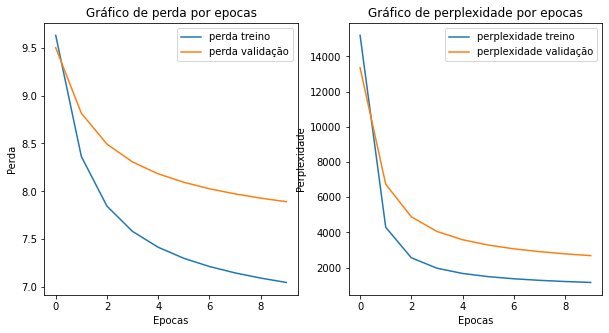

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# fig.set_title('Estado do modelo 10 épocas',fontsize= 25)

# plt.figure(figsize=(20,6))
ax1.set_title("Gráfico de perda por epocas")
ax1.plot(train_loss, label = 'perda treino')
ax1.plot(val_loss, label = 'perda validação')
ax1.set_xlabel("Epocas")
ax1.set_ylabel("Perda")
ax1.legend()

# ax2.figure(figsize=(20,6))
ax2.set_title("Gráfico de perplexidade por epocas")
ax2.plot(train_ppl, label = 'perplexidade treino')
ax2.plot(val_ppl, label = 'perplexidade validação')
ax2.set_xlabel("Epocas")
ax2.set_ylabel("Perplexidade")
ax2.legend()

plt.savefig("10_epochs_train.png", dpi=300)
plt.show()

In [31]:
## Visualizando o modelo em 10 iterações de geração de texto
torch.manual_seed(42)
test = 'EAP once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())

test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)

next_token = torch.argmax(model(test))

vocab_t[int(next_token)]

EAP_token = torch.tensor([44897]).to(device)
MWS_token = torch.tensor([44898]).to(device)
HPL_token = torch.tensor([44899]).to(device)

# print(EAP_token)

N = 10

print("Edgar Allan Poe")
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([EAP_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

print("Marry Shelley")
test = 'MWS once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())
test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([MWS_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

print("HP Lovecraft")
test = 'HPL once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())
test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([HPL_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

Edgar Allan Poe
EAP once upon a time suspected. "we'd raymond; leetle loot, profound, well,' afraid "alberto proprietors,



Marry Shelley
MWS once upon a time nicely tumultuously cygnus. bat yearns stapleton, ideal mass. gamekeepers osborne.



HP Lovecraft
HPL once upon a time vases, aspires background; homes, "feb. salary, awkwardly corresponded last. treasuries





In [32]:
filepath = 'model_10_epochs.pt'
torch.save(model.state_dict(), filepath)

In [33]:
# Training more 10 epochs
train_loss, val_loss, train_ppl, val_ppl = train(train_loader, val_loader, model, epoch = 10, optimizer = opt, criterion = loss_func, verbose = True)

EPOCH 1/10: trainning loss: 7.009887347721263 val loss: 7.860241764957465 | trainning ppl: 1107.5297321247742 val ppl: 2592.1469899695726
EPOCH 2/10: trainning loss: 6.975683610637443 val loss: 7.832617565266137 | trainning ppl: 1070.2885999177183 val ppl: 2521.5209884213546
EPOCH 3/10: trainning loss: 6.945404263309394 val loss: 7.807030538910801 | trainning ppl: 1038.3666859205803 val ppl: 2457.8211840177073
EPOCH 4/10: trainning loss: 6.918286742625322 val loss: 7.785112480515415 | trainning ppl: 1010.5871146971953 val ppl: 2404.536596282057
EPOCH 5/10: trainning loss: 6.893722930982798 val loss: 7.765232900971347 | trainning ppl: 986.065646496069 val ppl: 2357.207420495169
EPOCH 6/10: trainning loss: 6.871343472546562 val loss: 7.745924616322934 | trainning ppl: 964.2431301850658 val ppl: 2312.130369334401
EPOCH 7/10: trainning loss: 6.850814484436184 val loss: 7.729999021419044 | trainning ppl: 944.6499961428592 val ppl: 2275.5999739274303
EPOCH 8/10: trainning loss: 6.83181103074

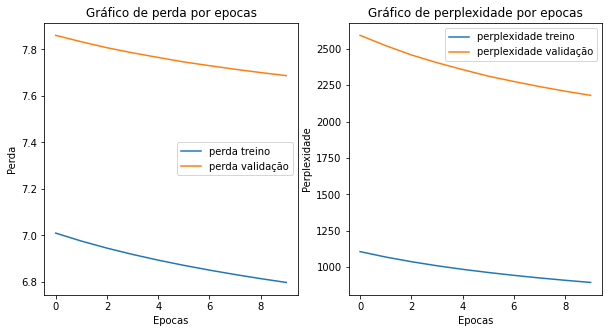

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

# fig.set_title('Estado do modelo 10 épocas',fontsize= 25)

# plt.figure(figsize=(20,6))
ax1.set_title("Gráfico de perda por epocas")
ax1.plot(train_loss, label = 'perda treino')
ax1.plot(val_loss, label = 'perda validação')
ax1.set_xlabel("Epocas")
ax1.set_ylabel("Perda")
ax1.legend()

# ax2.figure(figsize=(20,6))
ax2.set_title("Gráfico de perplexidade por epocas")
ax2.plot(train_ppl, label = 'perplexidade treino')
ax2.plot(val_ppl, label = 'perplexidade validação')
ax2.set_xlabel("Epocas")
ax2.set_ylabel("Perplexidade")
ax2.legend()

plt.savefig("20_epochs_train.png", dpi=300)
plt.show()

In [35]:
## Visualizando o modelo em 10 iterações de geração de texto
torch.manual_seed(42)
test = 'EAP once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())

test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)

next_token = torch.argmax(model(test))

vocab_t[int(next_token)]

EAP_token = torch.tensor([44897]).to(device)
MWS_token = torch.tensor([44898]).to(device)
HPL_token = torch.tensor([44899]).to(device)

# print(EAP_token)

N = 10

print("Edgar Allan Poe")
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([EAP_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

print("Marry Shelley")
test = 'MWS once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())
test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([MWS_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

print("HP Lovecraft")
test = 'HPL once upon a time'

decode_tokens = []
decode_tokens.extend(test.split())
test = [vocab[t] for t in test.split()]

test = torch.tensor(test).type(torch.long).to(device)
context = test
for i in range(N):
    next_token = decode_model(model(context), k = 10, p = 0.95, method='ns')
    
    context = torch.cat([HPL_token, context[2:], next_token[0]])
    
    decode_tokens.append(vocab_t[int(next_token.cpu()[0])][0])
    
# print(decode_tokens)
print(' '.join(decode_tokens))
print('\n\n')

Edgar Allan Poe
EAP once upon a time respite ermined unaltered, offered. elementary nuts, counts, validity use. torture



Marry Shelley
MWS once upon a time household lomond attribute thumb." cambridge, experienced. nations? countess 'snob' agile,



HP Lovecraft
HPL once upon a time flash moderate. patients," galleons. saucers super stores, intricate blush. puzzled,





In [36]:
filepath = 'model_20_epochs.pt'
torch.save(model.state_dict(), filepath)

# Visualizing in lower dimension

In [37]:
# Visualization in lower dimension
model.eval()

normalizador = 1

embeddings = []

with torch.no_grad():
  # Começo da avaliação em mini batches
  for x, y in val_loader:
    # Habilitando gpu 
    x = x.to(device)
    
    # Foward
    encoded = model.embedding(x)
    
    embeddings.extend(encoded.cpu().detach().tolist())

In [38]:
import umap
reducer = umap.UMAP()

umaps = reducer.fit_transform(np.array(embeddings))

umaps.shape

ModuleNotFoundError: No module named 'umap'

In [37]:
umap_df = pd.DataFrame({'u1': umaps[:,0], 'u2': umaps[:,1], 'targets': df_val_authors})
umap_df.head()

,u1,u2,targets
51367,10.791597,9.674500,44897
388580,13.208870,15.858609,44897
44587,12.129350,10.951943,44899
439304,9.374265,14.316199,44897
233289,21.646910,7.578076,44897


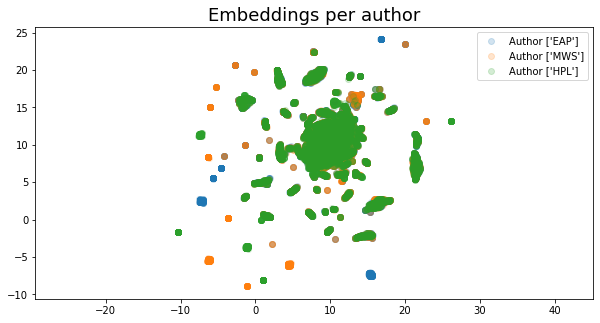

In [38]:
plt.figure(figsize = (10,5))
# plt.scatter(umaps[:, 0], umaps[:, 1], c=[sns.color_palette()[x] for x in np.array(targets_val).astype(int)])

for t in np.unique(df_val_authors):
  # if(t in [2,6]):
  plt.scatter(umap_df[umap_df.targets == t]['u1'], umap_df[umap_df.targets == t]['u2'], alpha =  0.2, label = f'Author {vocab_t[t]}')
  # plt.scatter(centroids[centroids['target'] == t]['x'],centroids[centroids['target'] == t]['y'], linewidths=5,label = f'CENTROID Emotion {map_emotion(t)}')
  
plt.legend()

plt.gca().set_aspect('equal', 'datalim')
plt.savefig("umap_embedding.png", dpi = 300)
plt.title('Embeddings per author', fontsize=18);